<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs

In [66]:
!pip install -q import_ipynb

In [106]:
# utils
import os, sys, warnings, itertools, tarfile
import import_ipynb
import pandas as pd
import numpy as np
from pprint import pprint
# colab
from google.colab import drive
# sklearn
from sklearn import set_config
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             f1_score,
                             roc_auc_score,
                             recall_score,
                             classification_report,
                             confusion_matrix)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
# vis
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

## Settings

In [68]:
warnings.filterwarnings('ignore')

In [69]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [71]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [72]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Dataset

In [73]:
curr_dir = os.getcwd()
curr_dir

'/content/drive/MyDrive/Jupyter Notebooks'

In [74]:
data_dir = os.path.join(curr_dir, "Inputs/titanic")

In [75]:
print("data_dir includes:", os.listdir(data_dir))

data_dir includes: ['gender_submission.csv', 'train.csv', 'test.csv']


In [76]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [77]:
reduce_memory_usage(train_df, category=True)

Memory usage of dataframe is 0.081696 MB!
Memory usage after optimization is 0.080069 MB!
Decreased by 2.0%


In [78]:
display_df(train_df)

Dataframe:  
num_rows = 891 
num_cols = 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.312500,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925781,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.093750,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.046875,NaN,S


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    int8    
 2   Pclass       891 non-null    int8    
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float16 
 6   SibSp        891 non-null    int8    
 7   Parch        891 non-null    int8    
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float16 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(5), float16(2), int16(1), int8(4)
memory usage: 82.0 KB
Number of null data points:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [79]:
summarize_columns(train_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,PassengerId,int16,0,0.0,891,1,2,3
1,Survived,int8,0,0.0,2,0,1,1
2,Pclass,int8,0,0.0,3,3,1,3
3,Name,category,0,0.0,891,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina"
4,Sex,category,0,0.0,2,male,female,female
5,Age,float16,177,19.9,88,22.0,38.0,26.0
6,SibSp,int8,0,0.0,7,1,1,0
7,Parch,int8,0,0.0,7,0,0,0
8,Ticket,category,0,0.0,681,A/5 21171,PC 17599,STON/O2. 3101282
9,Fare,float16,0,0.0,242,7.25,71.3125,7.925781


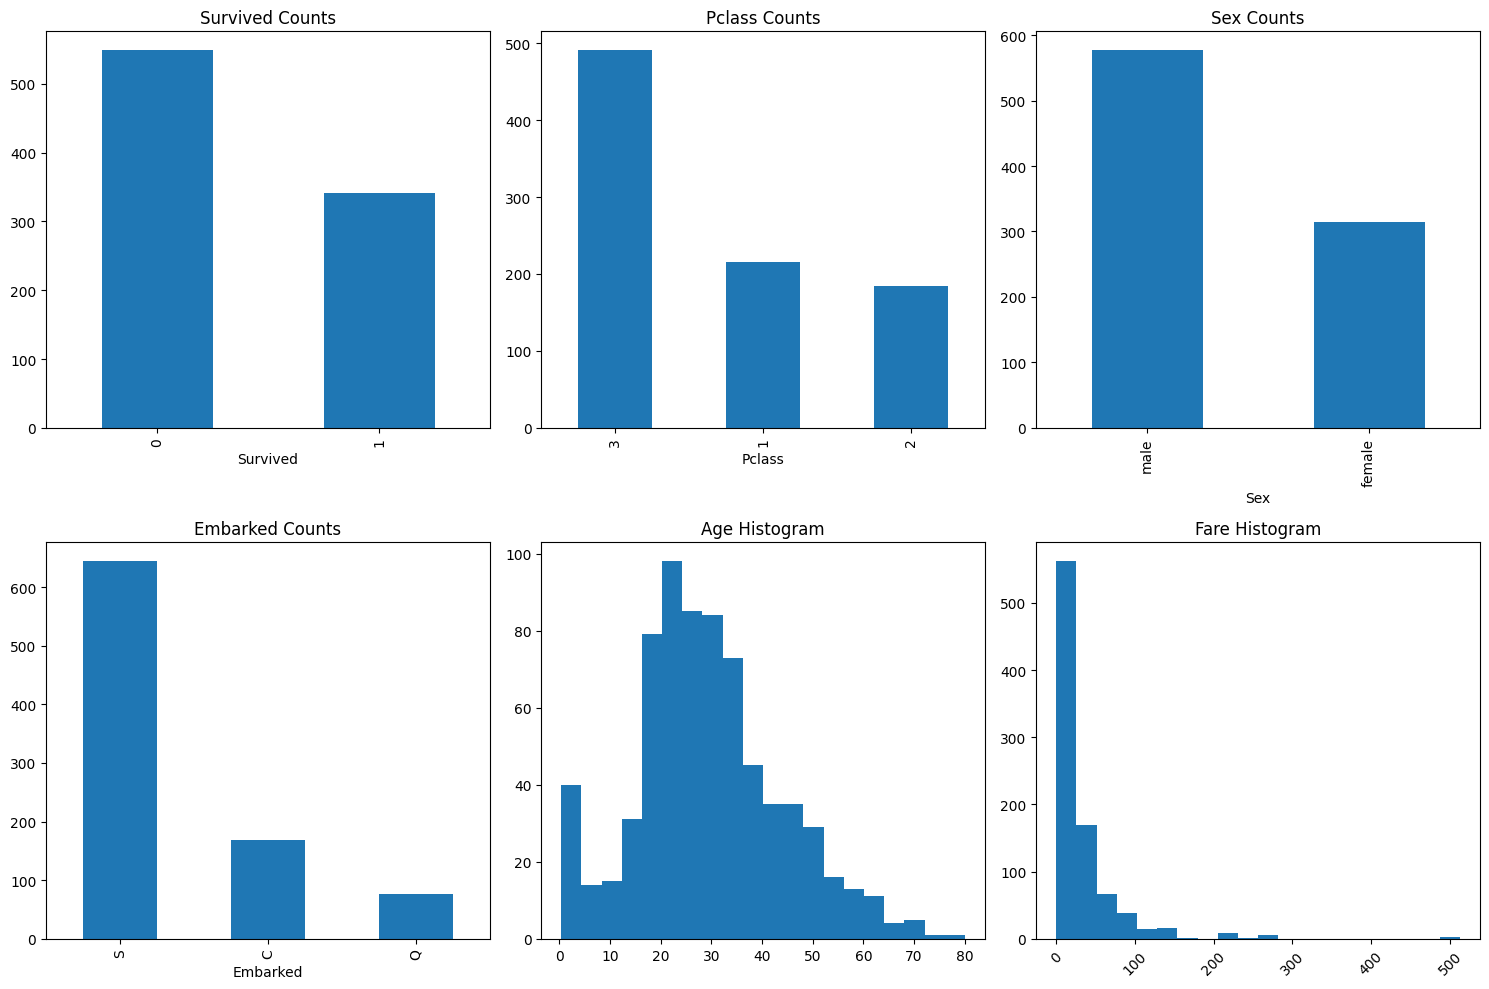

In [80]:
vars_to_plot = ["Survived",
                "Pclass",
                "Sex",
                "Embarked",
                "Age",
                "Fare"]

cts_vars = ["Age", "Fare"]
plot_variables(df=train_df, vars_to_plot=vars_to_plot, cts_vars=cts_vars, num_cols=3)

In [81]:
vars_to_plot = ["Pclass", "Sex", "Embarked", "SibSp", "Parch"]
data_frames = []
captions = []
for var in vars_to_plot:
    data_frames.append(pd.crosstab(train_df[var], train_df["Survived"]))
    captions.append("Survived counts by {}".format(var))
display_side_by_side(data_frames, captions, table_spacing=5)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119
Survived,0,1
Sex,,
female,81,233
male,468,109
Survived,0,1
Embarked,,


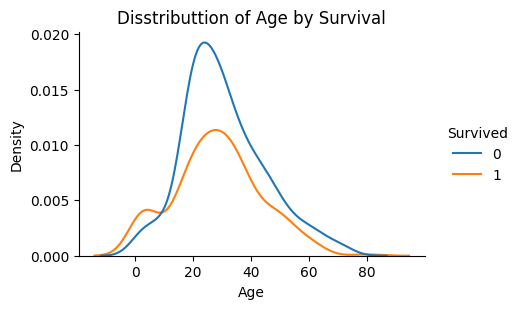

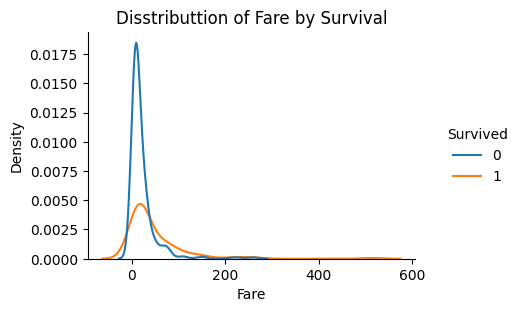

In [82]:
cts_vars = ["Age", "Fare"]
for var in cts_vars:
    sns.displot(x=var, kind="kde", hue="Survived", data=train_df, height=3, aspect=1.5)
    plt.title("Disstributtion of {} by Survival".format(var))
    plt.show()

In [83]:
print("Value counts:")
print(train_df["Embarked"].value_counts())
print("Number of missing data:", train_df["Embarked"].isna().sum())

Value counts:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Number of missing data: 2


In [84]:
def handle_missing_data(df):
    col_to_drop = ["PassengerId", "Name", "Cabin", "Ticket"]
    cat_col = ["Pclass", "Sex", "Embarked"]
    df["Embarked"].fillna("S", inplace=True)
    df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))
    df["Fare"] = df.groupby(["Sex", "Pclass"])["Fare"].transform(lambda x: x.fillna(x.median()))
    df["FamilySize"] = df.apply(lambda x: x["Parch"] + x["SibSp"], axis=1)
    df.drop(columns=col_to_drop, axis=1, inplace=True)
    one_hot_encoder = OneHotEncoder()
    one_hot_encoder.fit(df[cat_col])
    output = one_hot_encode(df=df, ohe=one_hot_encoder, var_list=cat_col, drop_original=True)
    return output

df = train_df.copy()
df = handle_missing_data(df)

y = train_df[["Survived"]]
X = train_df.drop("Survived", axis=1)

numerical_features = ["Age", "Fare"]
categorical_features = ["Embarked", "Sex", "Pclass"]
drop_features = ["PassengerId", "Name", "Cabin", "Ticket"]
unchanged_features = ["SibSp", "Parch"]


numeric_transformer = Pipeline(steps=[("impute", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())
                                     ]
                              )
categorical_transformer = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                         ]
                                  )
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_features),
                                               ("cat", categorical_transformer, categorical_features),
                                               ('drop', 'drop', drop_features),
                                               ('unchanged', 'passthrough', unchanged_features)
                                              ]
                                )
clf = Pipeline(steps=[("preprocessor", preprocessor),
                      ("classifier", RandomForestClassifier(n_estimators=100))])

set_config(display="diagram")
display(clf)
set_config(display="text")
print(clf)
print("Num of steps = {}".format(len(clf)))
print("Last step = {}".format(clf[-1]))


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)
clf.fit(X_train, y_train)
score_train = clf.score(X_train, y_train)
score_val = clf.score(X_val, y_val)
print("Accuracy on traing data: {:.2f}".format(score_train))
print("Accuracy on validation data: {:.2f}".format(score_val))

pred_val = clf.predict(X_val)

val_accuracy_score = accuracy_score(pred_val, y_val)
val_precision_score = precision_score(pred_val, y_val)
val_f1_score = f1_score(pred_val, y_val)
val_roc_auc_score = roc_auc_score(pred_val, y_val)
val_recall_score = recall_score(pred_val, y_val)

print("Validation Set Accuracy: {:.2f}".format(val_accuracy_score))
print("Validation Set Precision Score: {:.2f}".format(val_precision_score))
print("Validation Set F1 Score: {:.2f}".format(val_f1_score))
print("Validation Set ROC AUC Score: {:.2f}".format(val_roc_auc_score))
print("Validation Set Recall Score: {:.2f}".format(val_recall_score))

target_names = ["Survived", "Not Survived"]
report = classification_report(y_true=y_val, y_pred=pred_val, target_names=target_names, output_dict=True)
df = pd.DataFrame(report).transpose()
df

## Train Model

In [85]:
X = df.drop(columns=["Survived"], axis=1)
y = df["Survived"]

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

In [87]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [88]:
print(grid_search.best_params_)

{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [89]:
score_train = grid_search.best_estimator_.score(X_train, y_train)
print("Accuracy on traing data: {:.2f}".format(score_train))

Accuracy on traing data: 0.89


In [90]:
score_val = grid_search.best_estimator_.score(X_val, y_val)
print("Accuracy on validation data: {:.2f}".format(score_val))

Accuracy on validation data: 0.82


In [92]:
pred_val = grid_search.best_estimator_.predict(X_val)

In [93]:
val_accuracy = accuracy_score(y_val, pred_val)
val_precision = precision_score(y_val, pred_val)
val_f1 = f1_score(y_val, pred_val)
val_roc_auc = roc_auc_score(y_val, pred_val)
val_recall = recall_score(y_val, pred_val)

print(f"Validation set metrics:")
print(f"------------------------")
print(f"Accuracy       : {val_accuracy:.2f}")
print(f"Precision      : {val_precision:.2f}")
print(f"F1 Score       : {val_f1:.2f}")
print(f"ROC AUC Score  : {val_roc_auc:.2f}")
print(f"Recall         : {val_recall:.2f}")

Validation set metrics:
------------------------
Accuracy       : 0.82
Precision      : 0.82
F1 Score       : 0.74
ROC AUC Score  : 0.79
Recall         : 0.67


Confusion matrix, without normalization


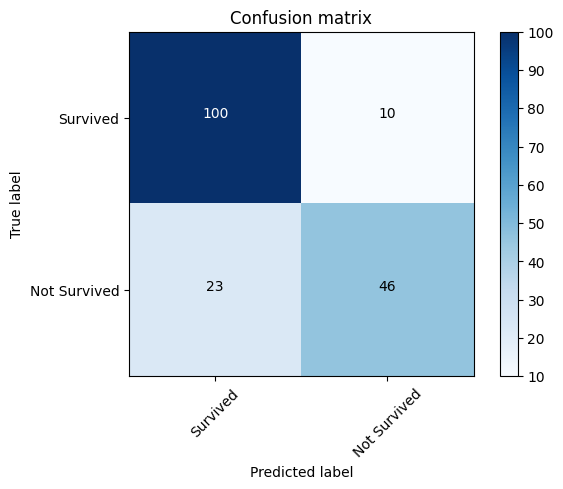

In [94]:
cm = confusion_matrix(y_true=y_val,
                      y_pred=pred_val)

cm_plot_labels = ["Survived", "Not Survived"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

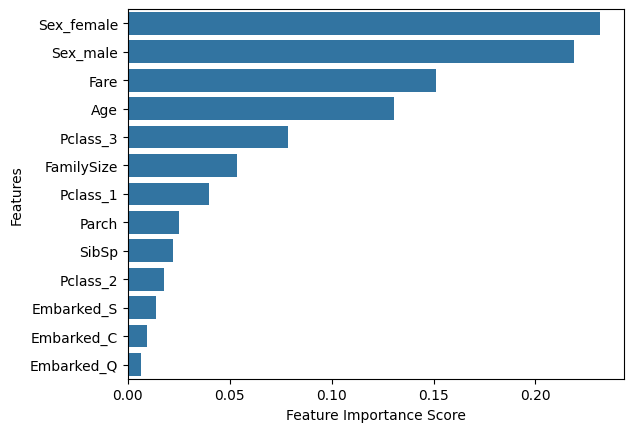

In [95]:
feature_imp = pd.Series(grid_search.best_estimator_.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

## Test Set

In [96]:
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [97]:
output = test_df[["PassengerId"]]

In [98]:
test_df = handle_missing_data(test_df)

In [99]:
output["Survived"] = grid_search.best_estimator_.predict(test_df)

In [100]:
display_df(output)

Dataframe:  
num_rows = 418 
num_cols = 2


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int8 
dtypes: int64(1), int8(1)
memory usage: 3.8 KB


<Axes: title={'center': 'Fare Counts'}, xlabel='Survived'>

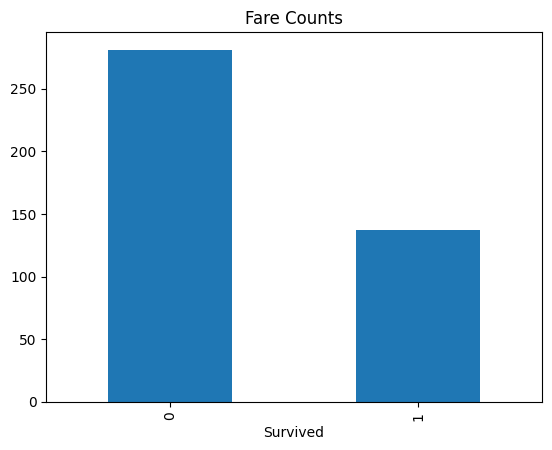

In [101]:
output["Survived"].value_counts().plot(kind="bar", title="{} Counts".format(var))

## Use Pipeline - Alternative Method

In [123]:
y = train_df[["Survived"]]
X = train_df.drop("Survived", axis=1)

In [124]:
numerical_features = ["Age", "Fare"]
categorical_features = ["Embarked", "Sex", "Pclass"]
drop_features = ["PassengerId", "Name", "Cabin", "Ticket"]
extra_features = ["SibSp", "Parch"]

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

In [126]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features),
    ("drop", "drop", drop_features),
    ("passthrough", "passthrough", extra_features)
    ])

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())])

In [127]:
%%time
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],
    "preprocessor__num__imputer__strategy": ['mean', 'median'],
    }

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

CPU times: user 12.6 s, sys: 911 ms, total: 13.5 s
Wall time: 7min 53s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [129]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'preprocessor__num__imputer__strategy': 'median'}
Best score: 0.8454939426770413


In [132]:
set_config(display="diagram")
display(grid_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex',
                                                   'Pclass']),
                                                 ('drop', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Cabin', 'Ticket']),
                                                 ('passthrough', 'passthrough',
                                                  ['SibSp', 'Parch'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=200))])

In [133]:
set_config(display="text")
print(grid_search.best_estimator_)
print("Num of steps = {}".format(len(clf)))
print("Last step = {}".format(clf[-1]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Se

In [134]:
score_train = grid_search.best_estimator_.score(X_train, y_train)
print("Accuracy on traing data: {:.2f}".format(score_train))

Accuracy on traing data: 0.88


In [135]:
score_test = grid_search.best_estimator_.score(X_test, y_test)
print("Accuracy on test data: {:.2f}".format(score_test))

Accuracy on test data: 0.80


In [136]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [137]:
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred)
    }

print("Test Set Metrics:")
print("-----------------")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name:<15}: {metric_value:.2f}")

Test Set Metrics:
-----------------
Accuracy       : 0.80
Precision      : 0.80
F1 Score       : 0.72
ROC AUC Score  : 0.78
Recall         : 0.65


In [138]:
target_names = ["Survived", "Not Survived"]
report = classification_report(y_true=y_test,
                               y_pred=y_pred,
                               target_names=target_names,
                               output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Survived,0.804878,0.900000,0.849785,110.000000
Not Survived,0.803571,0.652174,0.720000,69.000000
accuracy,0.804469,0.804469,0.804469,0.804469
macro avg,0.804225,0.776087,0.784893,179.000000
weighted avg,0.804374,0.804469,0.799756,179.000000
